In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM, Dense, Dropout
import time

2025-03-11 23:09:46.154358: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 23:10:00.096124: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 23:10:11.274644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741731016.780218  229563 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741731018.449695  229563 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 23:10:37.371687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
#data location
column_definition_path="./Data/column_definitions.xlsx"
airline_data_path="./Data/DS_airline_delay_causes.csv"

#import data to dataframes
flight_data_df=pd.read_csv(airline_data_path)
column_definition_df=pd.read_excel(column_definition_path)

In [3]:
#displaying first five rows
print("Displaying first five rows of Flight data")
flight_data_df.head()

Displaying first five rows of Flight data


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,Unnamed: 21
0,2009,11,AS,Alaska Airlines Inc.,DCA,"Washington, DC: Ronald Reagan Washington National",88.0,11.0,1.99,0.00,...,0.00,0.0,0.0,266.0,65.0,0.0,201.0,0.0,0.0,NaN
1,2009,11,AS,Alaska Airlines Inc.,DEN,"Denver, CO: Denver International",123.0,5.0,3.47,0.00,...,0.00,0.0,0.0,81.0,57.0,0.0,24.0,0.0,0.0,NaN
2,2009,11,AS,Alaska Airlines Inc.,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",66.0,6.0,1.28,0.69,...,0.00,0.0,0.0,176.0,64.0,11.0,101.0,0.0,0.0,NaN
3,2009,11,AS,Alaska Airlines Inc.,EWR,"Newark, NJ: Newark Liberty International",59.0,10.0,0.24,0.00,...,0.56,0.0,0.0,553.0,8.0,0.0,526.0,0.0,19.0,NaN
4,2009,11,AS,Alaska Airlines Inc.,HNL,"Honolulu, HI: Daniel K Inouye International",85.0,18.0,1.34,1.46,...,0.00,0.0,0.0,547.0,85.0,89.0,373.0,0.0,0.0,NaN


In [4]:
#getting basic info of the flight data 
flight_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73282 entries, 0 to 73281
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 73282 non-null  int64  
 1    month               73282 non-null  int64  
 2   carrier              73282 non-null  object 
 3   carrier_name         73282 non-null  object 
 4   airport              73282 non-null  object 
 5   airport_name         73282 non-null  object 
 6   arr_flights          73240 non-null  float64
 7   arr_del15            73211 non-null  float64
 8   carrier_ct           73240 non-null  float64
 9    weather_ct          73240 non-null  float64
 10  nas_ct               73240 non-null  float64
 11  security_ct          73240 non-null  float64
 12  late_aircraft_ct     73240 non-null  float64
 13  arr_cancelled        73240 non-null  float64
 14  arr_diverted         73240 non-null  float64
 15   arr_delay           73240 non-null 

In [5]:
# Count missing values per column
missing_values = flight_data_df.isnull().sum()

print("Missing values in the dataset:")
print(missing_values)

Missing values in the dataset:
year                       0
 month                     0
carrier                    0
carrier_name               0
airport                    0
airport_name               0
arr_flights               42
arr_del15                 71
carrier_ct                42
 weather_ct               42
nas_ct                    42
security_ct               42
late_aircraft_ct          42
arr_cancelled             42
arr_diverted              42
 arr_delay                42
 carrier_delay            42
weather_delay             42
nas_delay                 42
security_delay            42
late_aircraft_delay       42
Unnamed: 21            73282
dtype: int64


In [6]:
## DATASET CLEANUP ###

#Removing Unnamed: 21 feature
flight_data_df.drop('Unnamed: 21', axis=1, inplace=True)

#Removing Samples with missing values
flight_data_df.dropna(inplace=True)

#we observe space between some features, we remove them
flight_data_df.rename(columns=lambda x: x.lstrip() if x.startswith(' ') else x, inplace=True)

#check for duplicate data samples
duplicates = flight_data_df.duplicated().sum()
#print(f"Number of duplicate rows: {duplicates}\n")

#dropping duplicate rows
flight_data_df.drop_duplicates(inplace=True)

# Replace negative values in nas_ct and nas_delay with 0
flight_data_df["nas_ct"] = flight_data_df["nas_ct"].apply(lambda x: max(x, 0))
flight_data_df["nas_delay"] = flight_data_df["nas_delay"].apply(lambda x: max(x, 0))

# As airport code and airport denote the same value, we drop it. We do similar to carrier and carrier_code
flight_data_df.drop('carrier_name', axis=1, inplace=True)
flight_data_df.drop('airport_name', axis=1, inplace=True)

In [7]:
#getting current df.info
flight_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73211 entries, 0 to 73281
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 73211 non-null  int64  
 1   month                73211 non-null  int64  
 2   carrier              73211 non-null  object 
 3   airport              73211 non-null  object 
 4   arr_flights          73211 non-null  float64
 5   arr_del15            73211 non-null  float64
 6   carrier_ct           73211 non-null  float64
 7   weather_ct           73211 non-null  float64
 8   nas_ct               73211 non-null  float64
 9   security_ct          73211 non-null  float64
 10  late_aircraft_ct     73211 non-null  float64
 11  arr_cancelled        73211 non-null  float64
 12  arr_diverted         73211 non-null  float64
 13  arr_delay            73211 non-null  float64
 14  carrier_delay        73211 non-null  float64
 15  weather_delay        73211 non-null  floa

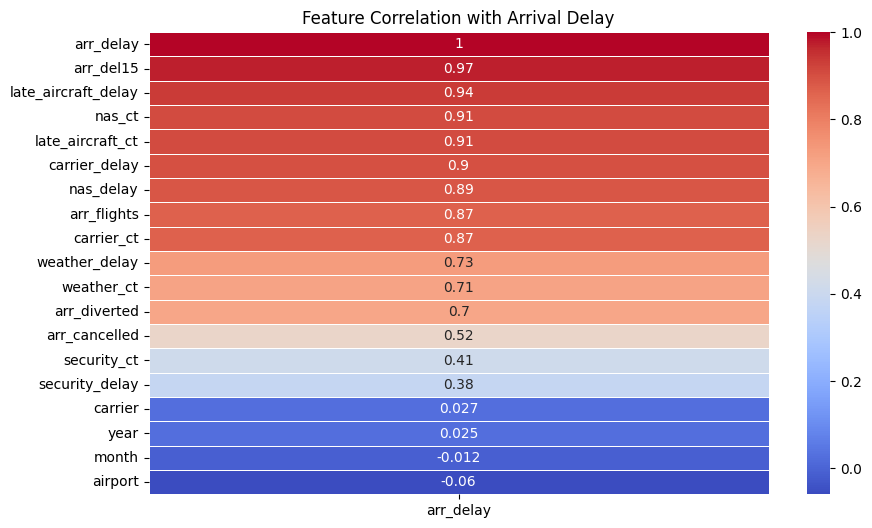

In [8]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['carrier', 'airport']

for col in categorical_cols:
    le = LabelEncoder()
    flight_data_df[col] = le.fit_transform(flight_data_df[col])
    label_encoders[col] = le

# Compute correlation matrix
corr_matrix = flight_data_df.corr()

# Plot heatmap of correlations with `arr_delay`
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[['arr_delay']].sort_values(by='arr_delay', ascending=False), 
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation with Arrival Delay")
plt.show()

In [9]:
#handling skewness

# Identify numerical columns (excluding categorical ones)
numerical_columns = flight_data_df.select_dtypes(include=["float64"]).columns #removing int64 as it only contains year, month, carrier and airport

# Calculate skewness for each numerical column
skewness = flight_data_df[numerical_columns].skew()

# Apply log transformation for high-skew columns (adding 1 to avoid log(0))
skewed_cols = skewness[skewness > 1].index
for col in skewed_cols:
    flight_data_df[col] = np.log1p(flight_data_df[col])

# Shift `nas_delay` to make all values positive
shift_constant = abs(flight_data_df["nas_delay"].min()) + 1  # Ensures positive values
flight_data_df["nas_delay"] = np.log1p(flight_data_df["nas_delay"] + shift_constant)

# Replace infinite values with NaN and then impute with median
flight_data_df = flight_data_df.replace([np.inf, -np.inf], np.nan).fillna(flight_data_df.median(numeric_only=True))

# Adjust limits as needed
flight_data_df.clip(lower=-1e10, upper=1e10, inplace=True)  

In [10]:
# Define features and target variable
features = ['carrier', 'airport', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 
            'nas_ct', 'security_ct', 'late_aircraft_ct', 'carrier_delay', 'weather_delay', 
            'nas_delay', 'security_delay', 'late_aircraft_delay']

X = flight_data_df[features].values
y = flight_data_df['arr_delay'].values

#normalising features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Measure execution time
start_time = time.time()

# Define MLP model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1)  # Output layer (regression task)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

# Evaluate the model on the test set
# (flatten() ensures predictions match the expected format of the true labels (y_test),
#  which is usually a 1D array.)
y_pred = model.predict(X_test).flatten()

# End time
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time


# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

/home2/bhattacharjee/miniconda3/envs/flightdata/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1741731289.053029  229563 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 7.6837 - val_loss: 0.1435
Epoch 2/50
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6527 - val_loss: 0.0859
Epoch 3/50
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4237 - val_loss: 0.1079
Epoch 4/50
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2704 - val_loss: 0.0519
Epoch 5/50
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1813 - val_loss: 0.0382
Epoch 6/50
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1376 - val_loss: 0.0437
Epoch 7/50
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1087 - val_loss: 0.0278
Epoch 8/50
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0901 - val_loss: 0.0216
Epoch 9/50
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0773 - val_loss: 0.0164
Epoch 10/50
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0696 - val_loss: 0.0259
Epoch 11/50
1831/1831 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0645 - val_loss: 0.0159
Epoch 12/50
1831/1831 ━━━━━━━━

In [11]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Square Error (MSE): {mse}")
print(f"R2 Sscore: {r2}")
print(f"Execution Time: {execution_time} seconds")

Mean Absolute Error (MAE): 0.11492824221484715
Mean Square Error (MSE): 0.025091136490681017
R2 Sscore: 0.9930201573483493
Execution Time: 119.76572012901306 seconds


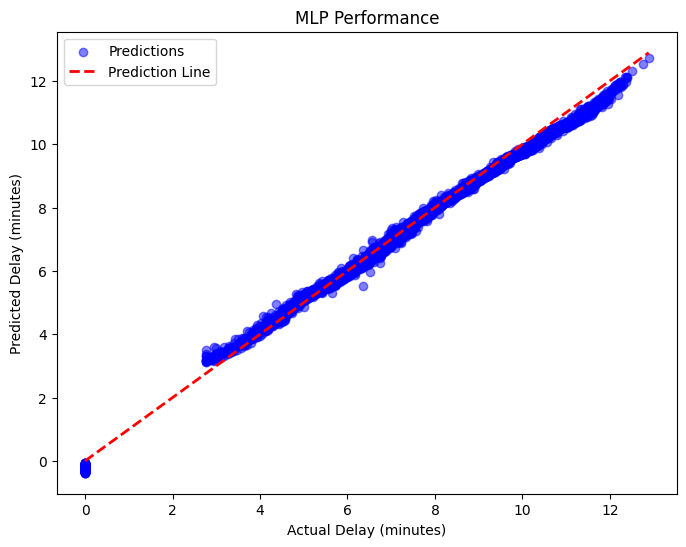

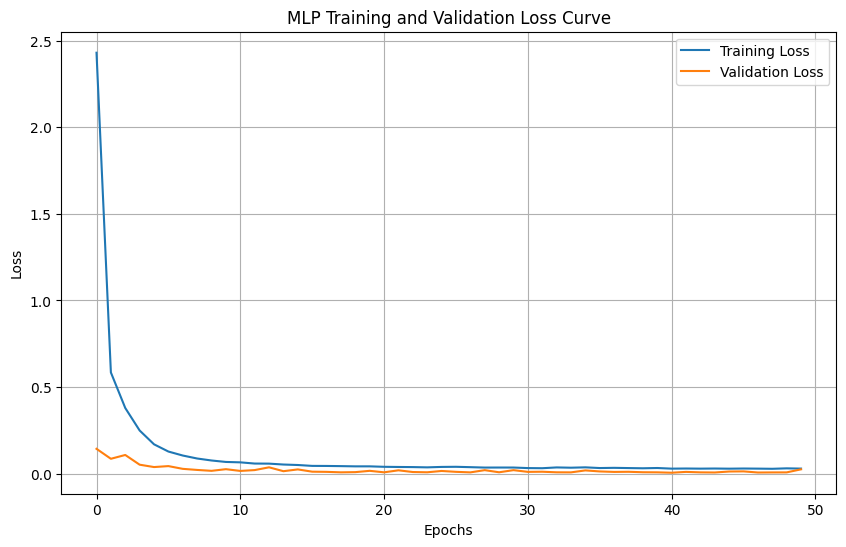

In [12]:
# Scatter plot: Actual vs Predicted Delays
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions", color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', linewidth=2, label="Prediction Line")
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Predicted Delay (minutes)")
plt.title("MLP Performance")
plt.legend()
plt.show()

# Plotting training & validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()